In [26]:
%load_ext tensorboard

import os
import tempfile
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint


## Simple example

In [2]:
def minimize_objective(config):
    score = config["a"] ** 2 + config["b"]
    return {"score": score}

search_space = {
    "a": tune.grid_search([0.001, 0.01, 0.1, 1.0]), # Iterate over these values
    "b": tune.choice([1, 2, 3]), # Randomly pick one of these values
}

storage_path = os.path.abspath("./ray_tune_test_results")

tuner = tune.Tuner(minimize_objective, param_space=search_space,
                    run_config=tune.RunConfig(storage_path=storage_path,
                                              name="test") ) # Specify a valid directory

results = tuner.fit()
print(results.get_best_result(metric="score", mode="min").config)


2025-03-22 16:45:08,891	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/xwen/git_repos_linux/RayTune/ray_tune_test_results/test' in 0.0038s.
2025-03-22 16:45:08,894	INFO tune.py:1041 -- Total run time: 1.12 seconds (1.09 seconds for the tuning loop).


{'a': 1.0, 'b': 1}


(train_mnist pid=355625) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/xwen/ray_results/train_mnist_2025-03-22_17-15-21/train_mnist_e8c7e_00000_0_momentum=0.7817_2025-03-22_17-15-21/checkpoint_000000)
(train_mnist pid=355625) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/xwen/ray_results/train_mnist_2025-03-22_17-15-21/train_mnist_e8c7e_00000_0_momentum=0.7817_2025-03-22_17-15-21/checkpoint_000001)
(train_mnist pid=364462) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/xwen/ray_results/train_mnist_2025-03-22_17-36-01/train_mnist_cbbc3_00019_19_momentum=0.7794_2025-03-22_17-36-01/checkpoint_000000)
(train_mnist pid=364462) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/xwen/ray_results/train_mnist_2025-03-22_17-36-01/train_mnist_cbbc3_00019_19_momentum=0.7794_2025-03-22_17-36-01/checkpoint_000001)


## Pytorch model tunning example

In [4]:
# Example of using a PyTorch model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # Can be super().__init__() in Python 3
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192) # Reshape
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

EPOCH_SIZE = 100
TEST_SIZE = 256    
def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # Zero out the gradients
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() # Compute the gradients
        optimizer.step() # Update the weights

def test_func(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient tracking
        for batch_idx, (data, target) in enumerate(test_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, dim = 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

In [6]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=128,
        shuffle=True)
    
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir: # Create a temporary directory
            checkpoint = None
            if (i + 1) % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir) # Save the checkpoint

            # Send the current training result back to Tune
            tune.report({"mean_accuracy": acc}, checkpoint=checkpoint)

In [7]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())), # Randomly sample from (10**-10, 1]
    "momentum": tune.uniform(0.1, 0.9), # Uniformly sample from (0.1, 0.9)
}

datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(train_mnist, param_space=search_space,)
results = tuner.fit()

2025-03-22 17:15:25,189	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/xwen/ray_results/train_mnist_2025-03-22_17-15-21' in 0.0016s.
2025-03-22 17:15:25,192	INFO tune.py:1041 -- Total run time: 3.57 seconds (3.56 seconds for the tuning loop).


In [13]:
import pandas as pd
metrics_df = []
for result in results:
    metrics_df.append(result.metrics_dataframe)
metrics_df = pd.concat(metrics_df)
metrics_df

,mean_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/lr,config/momentum,should_checkpoint
0,0.093750,1742688924,None,False,1,e8c7e_00000,2025-03-22_17-15-24,0.478919,0.478919,355625,Xiaoyu-PC,172.29.217.236,0.478919,1,8.173762e-08,0.781722,NaN
1,0.072917,1742688924,None,False,2,e8c7e_00000,2025-03-22_17-15-24,0.047119,0.526037,355625,Xiaoyu-PC,172.29.217.236,0.526037,2,8.173762e-08,0.781722,NaN
2,0.088542,1742688924,None,False,3,e8c7e_00000,2025-03-22_17-15-24,0.042293,0.568330,355625,Xiaoyu-PC,172.29.217.236,0.568330,3,8.173762e-08,0.781722,NaN
3,0.109375,1742688924,None,False,4,e8c7e_00000,2025-03-22_17-15-24,0.046684,0.615014,355625,Xiaoyu-PC,172.29.217.236,0.615014,4,8.173762e-08,0.781722,NaN
4,0.075521,1742688924,checkpoint_000000,False,5,e8c7e_00000,2025-03-22_17-15-24,0.044741,0.659755,355625,Xiaoyu-PC,172.29.217.236,0.659755,5,8.173762e-08,0.781722,True
5,0.080729,1742688924,None,False,6,e8c7e_00000,2025-03-22_17-15-24,0.047235,0.706990,355625,Xiaoyu-PC,172.29.217.236,0.706990,6,8.173762e-08,0.781722,NaN
6,0.080729,1742688925,None,False,7,e8c7e_00000,2025-03-22_17-15-25,0.044305,0.751295,355625,Xiaoyu-PC,172.29.217.236,0.751295,7,8.173762e-08,0.781722,NaN
7,0.078125,1742688925,None,False,8,e8c7e_00000,2025-03-22_17-15-25,0.044326,0.795620,355625,Xiaoyu-PC,172.29.217.236,0.795620,8,8.173762e-08,0.781722,NaN
8,0.104167,1742688925,None,False,9,e8c7e_00000,2025-03-22_17-15-25,0.045887,0.841507,355625,Xiaoyu-PC,172.29.217.236,0.841507,9,8.173762e-08,0.781722,NaN
9,0.088542,1742688925,checkpoint_000001,False,10,e8c7e_00000,2025-03-22_17-15-25,0.046588,0.888095,355625,Xiaoyu-PC,172.29.217.236,0.888095,10,8.173762e-08,0.781722,True


[<Axes: >]

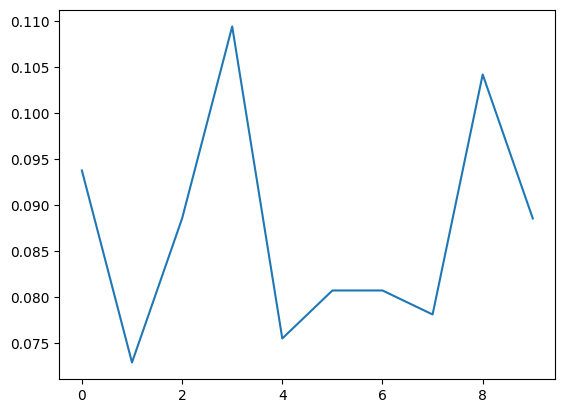

In [10]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

In [18]:
dfs

{'/home/xwen/ray_results/train_mnist_2025-03-22_17-15-21/train_mnist_e8c7e_00000_0_momentum=0.7817_2025-03-22_17-15-21':    mean_accuracy   timestamp checkpoint_dir_name   done  training_iteration  \
 0       0.093750  1742688924                None  False                   1   
 1       0.072917  1742688924                None  False                   2   
 2       0.088542  1742688924                None  False                   3   
 3       0.109375  1742688924                None  False                   4   
 4       0.075521  1742688924   checkpoint_000000  False                   5   
 5       0.080729  1742688924                None  False                   6   
 6       0.080729  1742688925                None  False                   7   
 7       0.078125  1742688925                None  False                   8   
 8       0.104167  1742688925                None  False                   9   
 9       0.088542  1742688925   checkpoint_000001  False                  10   


### Add ASHA scheduler

In [19]:
# ASHA: a scalable algorithm for principled early stopping
tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=20, # Number of trials
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()
dfs = {result.path: result.metrics_dataframe for result in results}

2025-03-22 17:36:09,655	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/xwen/ray_results/train_mnist_2025-03-22_17-36-01' in 0.0134s.
2025-03-22 17:36:09,662	INFO tune.py:1041 -- Total run time: 8.28 seconds (8.25 seconds for the tuning loop).


Text(0, 0.5, 'Mean Accuracy')

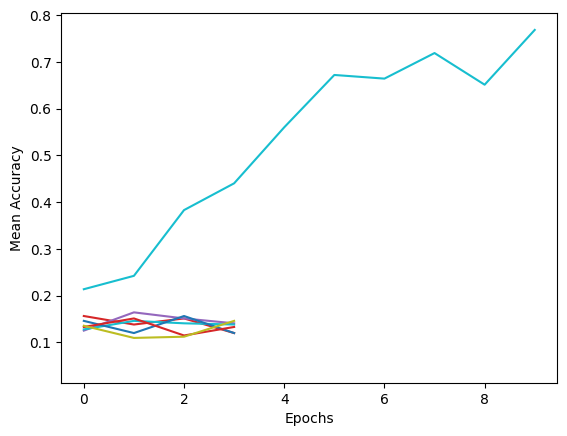

In [22]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")

### Add search algorithm